In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import yt
import yt.units as u
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Times"]})

In [3]:
from astropy.convolution import Gaussian2DKernel
from astropy.convolution import convolve
from scipy.interpolate import splev, splrep, interp1d, splint

## Tidal Force Comparison

### Direct Comparison


$$
\begin{align*}
\Delta F_T(t,e)&=\left[\frac{GM}{(r(t,e)-R_*)^2}-\frac{GM}{(r(t,e)+R_*)^2}\right]\\
&\simeq GMr^{-2}(t,e)\cdot \frac{4R_*}{r(t,e)}\\
&=\frac{4GMR_*}{r^3(t,e)}
\end{align*}
$$

In a Keplerian orbit, the radial distance $r$ is related to the eccentric anomaly $E$

$$
r=a(1-e\cos E)
$$

where $E$ satisfies

$$
E - e\sin E=\frac{2\pi (t-t_0)}{P}
$$

so that

$$
\Delta F_T(t,e) = \frac{4GMR_*}{r_p^3}(1-e)^3\xi^{-3}
$$

Here

$$
\quad \xi=\frac ra=1-e\cos E
$$

<ipython-input-4-09e9e1ab4f23>:13: RuntimeWarning: divide by zero encountered in true_divide
  xi = (1 + e) / (1 + e * np.cos(E))  #1 - e * np.cos(E)
<ipython-input-4-09e9e1ab4f23>:13: RuntimeWarning: divide by zero encountered in true_divide
  xi = (1 + e) / (1 + e * np.cos(E))  #1 - e * np.cos(E)
<ipython-input-4-09e9e1ab4f23>:13: RuntimeWarning: divide by zero encountered in true_divide
  xi = (1 + e) / (1 + e * np.cos(E))  #1 - e * np.cos(E)
<ipython-input-4-09e9e1ab4f23>:13: RuntimeWarning: divide by zero encountered in true_divide
  xi = (1 + e) / (1 + e * np.cos(E))  #1 - e * np.cos(E)


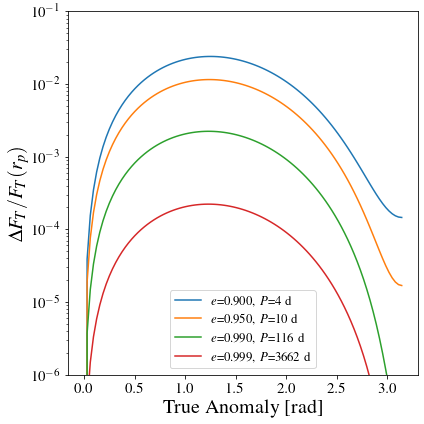

In [4]:
rT = u.Rsun * (7.7e7)**(1 / 3)
P0 = 2 * np.pi * np.sqrt(rT**3 / u.gravitational_constant / 7.7e7 / u.Msun)
def P(e):
    return (P0.in_units('day').v * (1-e)**(-3 / 2))

def FTt(tau, e):
    E = lambda psi: psi - e * np.sin(psi) - 2 * np.pi * tau
    xi = 1 - e * np.cos(fsolve(E, [1]))
    return xi**(-3) * (1 - e)**3


def FT(E, e):
    xi = (1 + e) / (1 + e * np.cos(E))  #1 - e * np.cos(E)
    return xi**(-3)

f, ax = plt.subplots(figsize=(6, 6))
e_arr = np.array([0.90, 0.95, 0.99, 0.999])
tau = np.linspace(0, .5, 100)
E = np.linspace(0, np.pi, 101)
for e in e_arr:
    Fe = (FT(E, e) - FT(E, 1)) / FT(0, 1)
    ax.plot(E, Fe, label=r'$e$={:.3f}, $P$={:.0f} d'.format(e, P(e)))
ax.tick_params(labelsize=15)
ax.set_yscale('log')
ax.set_xlabel(r'True Anomaly [rad]', fontsize=20)
ax.set_ylabel(r'$\Delta F_T/F_T(r_p)$', fontsize=20)
ax.set_ylim(1e-6, 1e-1)
ax.legend(prop={'size': 13})
f.tight_layout()

### Half Period (from Pericenter to Apocenter)

$$
\begin{align*}
\Delta I&=\int_{t(r_\text{min})}^{t(r_\text{max})}\Delta F_T(t,e)\text dt\\
&=4GMR_*\int_{t(r_\text{min})}^{t(r_\text{max})}r^{-3}(t,e)\text dt
\end{align*}
$$

In a Keplerian orbit, the radial distance $r$ is related to the eccentric anomaly $E$

$$
r=a(1-e\cos E)
$$

where $E$ satisfies

$$
E - e\sin E=\frac{2\pi (t-t_0)}{P}
$$

Now we take

$$
t_0=t(r_\text{min})=0,\quad t(r_\text{max})=\frac P2
$$

and define

$$
\tau\equiv\frac tP,\quad F(e)=(1-e)^{3/2}\int_{0}^{1/2}\xi^{-3}(\tau, e)\text d\tau
$$

so that

$$
\Delta I=4GMR_*Pa^{-3}\int_{0}^{1/2}\xi^{-3}(\tau, e)\text d\tau\equiv 8\pi R_*\sqrt{\frac{GM}{r_p^3}}F(e)
$$

and

$$
E-e\sin E=2\pi\tau,\quad \xi=1-e\cos E
$$

In [5]:
from scipy.optimize import fsolve, brentq
from scipy.integrate import simps, quad


def F(e_arr, N=10000):
    res = []
    err = []
    for e in e_arr:

        def xi(tau):
            E = lambda psi: psi - e * np.sin(psi) - 2 * np.pi * tau
            xi = 1 - e * np.cos(fsolve(E, [1]))
            return xi

        f = lambda tau: 1 / xi(tau)**3 * (1 - e)**(3 / 2)

        integral = quad(f, 0, 0.5)
        res.append(integral[0])
        err.append(integral[1])
    return np.array(res), np.array(err)


e_arr = np.linspace(0.9, 0.995, 100)
res, err = F(e_arr, N=100)
res /= res[-1]
e_cri_1 = e_arr[abs(1 - res / res[-1]) <= 0.01][0]
e_cri_5 = e_arr[abs(1 - res / res[-1]) <= 0.05][0]

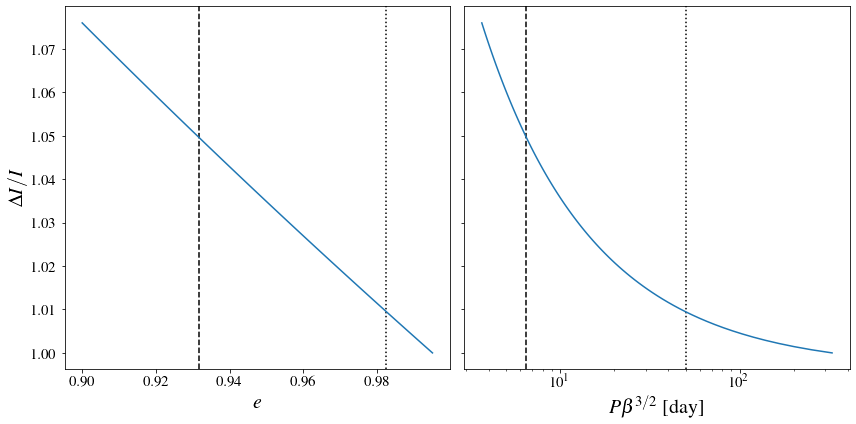

In [6]:
f, ax = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
ax[0].errorbar(e_arr, res, yerr=err)
ax[0].axvline(e_cri_1, color='k', linestyle=':')
ax[0].axvline(e_cri_5, color='k', linestyle='--')
ax[0].set_xlabel('$e$', fontsize=20)
ax[0].set_ylabel(r'$\Delta I/I$', fontsize=20)
ax[1].errorbar(P(e_arr), res, yerr=err)
ax[1].axvline(P(e_cri_1), color='k', linestyle=':')
ax[1].axvline(P(e_cri_5), color='k', linestyle='--')
ax[1].set_xlabel(r'$P\beta^{3/2}$ [day]', fontsize=20)
ax[1].set_xscale('log')
for a in ax:
    a.tick_params(labelsize=15)
f.tight_layout()

In [7]:
e_cri_1, e_cri_5

(0.9825252525252526, 0.9316666666666666)

### $\beta$ Decreases by a Factor of 10

$$
\Delta I_{10}=4GMR_*\int_{t(r_p)}^{t(10r_p)}r^{-3}(t,e)\text dt
$$

In [8]:
def F10(e_arr, N=1000):
    res = []
    err = []
    factor = 10
    for e in e_arr:

        def xi(tau):
            E = lambda psi: psi - e * np.sin(psi) - 2 * np.pi * tau
            xi = 1 - e * np.cos(fsolve(E, [1]))
            return xi

        f = lambda tau: 1 / xi(tau)**3 * (1 - e)**(3 / 2)

        def tau_cri(xi0, factor=10):
            y = lambda tau: xi(tau) - factor * xi0
            return brentq(y, 0, 0.5)
        tauc = tau_cri(xi0=xi(0), factor=factor)
        integral = quad(f, 0, tauc)
        res.append(integral[0])
        err.append(integral[1])
    return np.array(res), np.array(err)


e_arr = np.linspace(0.9, 0.995, 100)
res10, err10 = F10(e_arr, N=100)
res10 /= res10[-1]
e10_cri_1 = e_arr[abs(1 - res10 / res10[-1]) <= 0.01][0]
e10_cri_5 = e_arr[abs(1 - res10 / res10[-1]) <= 0.05][0]

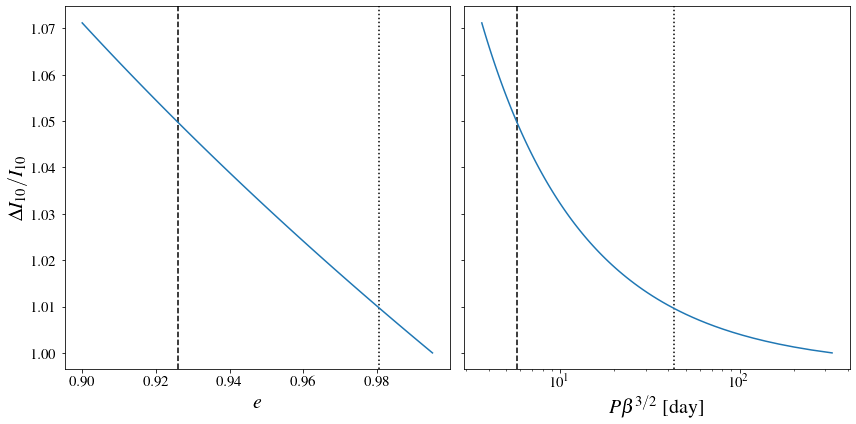

In [9]:
f, ax = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
ax[0].errorbar(e_arr, res10, yerr=err)
ax[0].axvline(e10_cri_1, color='k', linestyle=':')
ax[0].axvline(e10_cri_5, color='k', linestyle='--')
ax[0].set_xlabel('$e$', fontsize=20)
ax[0].set_ylabel(r'$\Delta I_{10}/I_{10}$', fontsize=20)
ax[1].errorbar(P(e_arr), res10, yerr=err)
ax[1].axvline(P(e10_cri_1), color='k', linestyle=':')
ax[1].axvline(P(e10_cri_5), color='k', linestyle='--')
ax[1].set_xlabel(r'$P\beta^{3/2}$ [day]', fontsize=20)
ax[1].set_xscale('log')
for a in ax:
    a.tick_params(labelsize=15)
f.tight_layout()

## Critical $e$ for Eccentric TDEs

In [10]:
import matplotlib.colors as colors

In [11]:
def e_cri_ecc(q, beta):
    return 1 - 2 * q**(-1 / 3) / beta


def e_cri_ecc_beta(q, e):
    return ((1 - e) / 2 * q**(1 / 3))**(-1)


def e_cri_tp(q, beta):
    factor = 3**(2 / 3) - 1
    return 1 - 2 * q**(-1 / 3) * factor * beta


def e_cri_tp_beta(q, e):
    factor = 3**(2 / 3) - 1
    return (1 - e) / 2 * q**(1 / 3) / factor


e_cri_1 = e_arr[abs(1 - res / res[-1]) <= 0.01][0]
e_cri_5 = e_arr[abs(1 - res / res[-1]) <= 0.05][0]

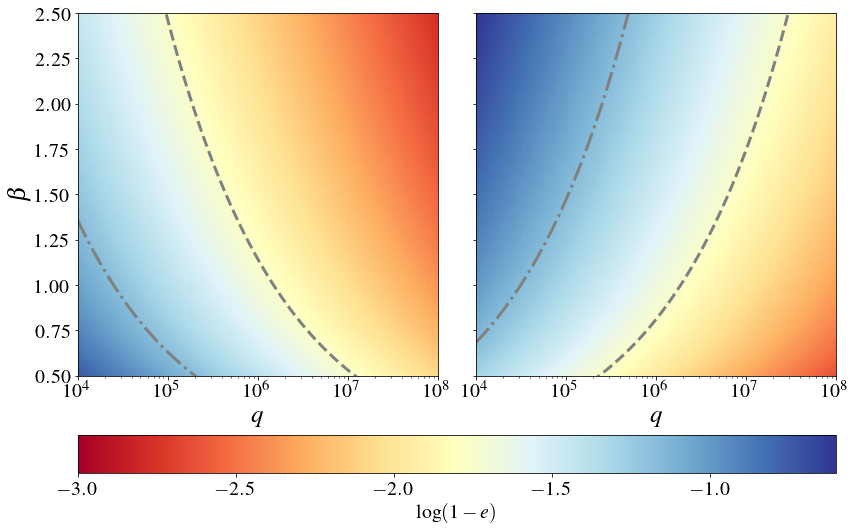

In [30]:
f, ax = plt.subplots(1, 2, figsize=(12, 8), sharex=True, sharey=True)
Q = np.logspace(4, 8, 100)
Beta = np.linspace(0.5, 2.5, 100)
q, beta = np.meshgrid(Q, Beta)
cm = plt.cm.get_cmap('RdYlBu')
e1, e2 = e_cri_ecc(q, beta), e_cri_tp(q, beta)
sc1 = ax[0].scatter(q,
                    beta,
                    c=np.log10(1 - e1),
                    cmap=cm,
                    vmin=-3,
                    marker='s',
                    vmax=np.log10(0.25),
                    #norm=colors.LogNorm(vmin=1e-3, vmax=0.25),
                    s=20)
ax[0].plot(Q,
           e_cri_ecc_beta(Q, e_cri_1),
           color='grey',
           linestyle='--',
           linewidth=3)
ax[0].plot(Q,
           e_cri_ecc_beta(Q, e_cri_5),
           color='grey',
           linestyle='-.',
           linewidth=3)
sc2 = ax[1].scatter(q,
                    beta,
                    c=np.log10(1 - e2),
                    cmap=cm,
                    marker='s',
                    vmin=-3,
                    vmax=np.log10(0.25),
                    #norm=colors.LogNorm(vmin=1e-3, vmax=0.25),
                    s=20)
ax[1].plot(Q,
           e_cri_tp_beta(Q, e_cri_1),
           color='grey',
           linestyle='--',
           linewidth=3)
ax[1].plot(Q,
           e_cri_tp_beta(Q, e_cri_5),
           color='grey',
           linestyle='-.',
           linewidth=3)
ax[0].set_xscale('log')
ax[0].set_xlim(1e4, 1e8)
ax[0].set_ylim(0.5, 2.5)
ax[0].set_xlabel('$q$', fontsize=25)
ax[1].set_xlabel('$q$', fontsize=25)
ax[0].set_ylabel(r'$\beta$', fontsize=25)
ax[0].tick_params(labelsize=20)
ax[1].tick_params(labelsize=20)
'''cbar2 = f.colorbar(sc2,
                   ax=ax[1],
                   label='1-$e$',
                   orientation="horizontal")'''
f.tight_layout()
cbar1 = f.colorbar(sc1,
                   ax=ax.ravel().tolist(),
                   orientation="horizontal",
                   pad=0.12)
cbar1.ax.tick_params(labelsize=20)
cbar1.set_label('$\log(1-e)$', size=20)
f.savefig('Critical_Ecc.pdf', bbox_inches='tight')